# Logistic Regression: Finding Geographic Crime Clusters
## A Work In Progress . . .

__Goal:__ generate an alternative map of Manhattan's borough boundaries using reported crime statistics.
  * Which borough regions cluster together in terms of reported crime rates?
  * What would NYC's borough boundaries look like if they were redrawn to reflect variations in reported crime statistics?

We'll useg K-means clustering to identify boroughs.  The five boroughs' present boundaries (based on legislatvely defined boundary lines instead of crime statistics) look like this:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/5_Boroughs_Labels_New_York_City_Map.svg/1200px-5_Boroughs_Labels_New_York_City_Map.svg.png' width='300'>

## Loading NYC crime statistics; plotting each crime's location (latitude and longitude)

In [ ]:
% matplotlib inline

In [1]:
import urllib2
import csv
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import pylab as pl
import re
import time
import scipy.stats
import scipy.optimize
import random
import copy

In [4]:
data = pd.read_csv('processed_nyc_crime_data.csv', sep=' ')
data.head()

,date,offense,offense_pd_description,attempted_completed,borough,lat,lon,is_violent_crime
0,2015-12-31,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",COMPLETED,BRONX,40.828848,-73.916661,False
1,2015-12-31,MURDER & NON-NEGL. MANSLAUGHTER,NaN,COMPLETED,QUEENS,40.697338,-73.784557,True
2,2015-12-31,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,INTENT TO",COMPLETED,MANHATTAN,40.802607,-73.945052,False
3,2015-12-31,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,QUEENS,40.654549,-73.726339,True
4,2015-12-31,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,MANHATTAN,40.738002,-73.987891,True


In [558]:
lats, lons, boroughs = [data['lat'].values, 
                        data['lon'].values, 
                        data['borough'].values]

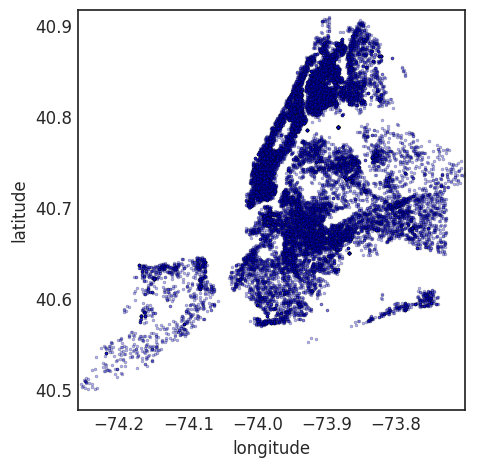

In [528]:
N = 100
pl.figure(figsize=(5,5))
x, y = lons[::N], lats[::N]
pl.plot(x, y, 'bo', markersize=2, alpha=0.3)
pl.ylim(ymin, ymax)
pl.xlim(xmin, xmax)
pl.xlabel('longitude')
pl.ylabel('latitude')
pl.show()

## Coloring each crime location according to its borough:

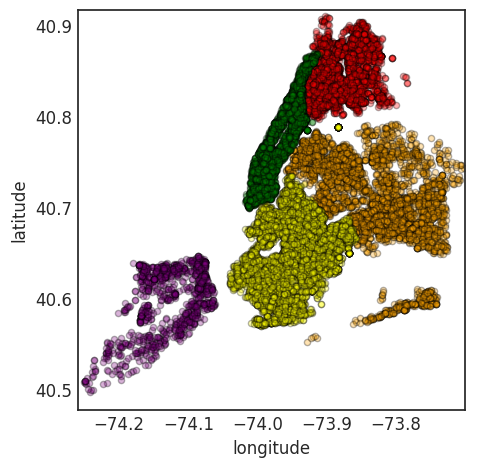

In [529]:
borough_names = ['BRONX', 'QUEENS', 'MANHATTAN', 'BROOKLYN', 'STATEN ISLAND']
colors = ['red', 'orange', 'green', 'yellow', 'purple']
N = 100

pl.figure(figsize=(5,5))
for boro, color in zip(borough_names, colors):
    valid = (boroughs == boro)
    x, y = lons[valid], lats[valid]
    pl.scatter(x[::N], y[::N], color=color, marker='o', edgecolor='k', alpha=0.3)
pl.ylim(ymin, ymax)
pl.xlim(xmin, xmax)
pl.xlabel('longitude')
pl.ylabel('latitude')
pl.show()

## Generating new borough boundaries by K-Means clustering the crime statistics:

In [559]:
K = 6 # number of centroids to look for

xmin, xmax = -74.26, -73.70 # longitude limits
ymin, ymax = 40.48, 40.92   # latitude limits

def generate_lonlat_matrix(lons, lats, N=100):
    """
    lat, lon = numpy arrays of latitude, longitude for each crime sample
    N = downsampling rate: by default, retain only every 100 samples
    Output: matrix with dim=(n, 2): n samples, each with 2 coordinates
    """
    lon_vector, lat_vector = copy.copy(lons), copy.copy(lats)
    return np.column_stack((lon_vector[::N], lat_vector[::N]))

X = generate_lonlat_matrix(lons, lats)
print X.shape


def initialize_centroids(X, K):
    rand_indices = random.sample(range(0, X.shape[0]), K)
    return np.array([X[i] for i in rand_indices])

initial_centroids = initialize_centroids(X, K)

(24361, 2)


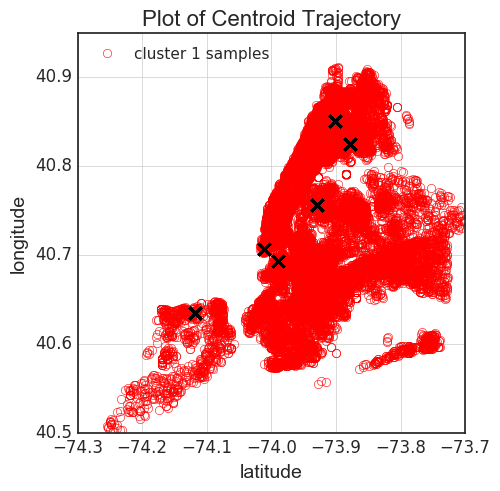

In [560]:
def plot_data(X, centroids, idxs=None):
    """
    X = matrix with dim=(n, 2), i.e., n samples, each with 2 coordinates
    idxs = index vector of latest iteration;
    centroids = vector of centroids, one per iteration
    """
    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']
    #If idxs is supplied, divide X into colors
    if idxs is not None:
        subX = []
        for x in range(centroids[0].shape[0]):
            subX.append(np.array([X[i] for i in range(X.shape[0]) if idxs[i] == x]))
    else:
        subX = [X]

    fig = pl.figure(figsize=(5,5))
    for x in range(len(subX)):
        newX = subX[x]
        pl.plot(newX[:,0], newX[:,1], 'o', markeredgecolor=colors[x], 
                markerfacecolor='None', alpha=0.8, label='cluster %s samples' % (int(x)+1))
    pl.xlabel('latitude', fontsize=14)
    pl.ylabel('longitude', fontsize=14)
    pl.title('Plot of Centroid Trajectory', fontsize=16)
    pl.grid()
    # Draw a history of centroid movement
    tempx, tempy = [], []
    for centroid in centroids:
        tempx.append(centroid[:,0])
        tempy.append(centroid[:,1])
    for x in xrange(len(tempx[0])):
        pl.plot(tempx, tempy, 'kx-', markersize=8, markeredgewidth=2)
    pl.legend(loc='best', fontsize=11, framealpha=0.5)

plot_data(X, [initial_centroids])

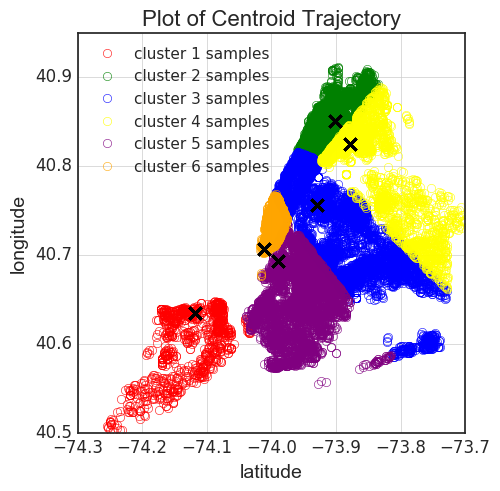

In [561]:
def distSquared(x1, x2):
    assert x1.shape == x2.shape
    return ((x2 - x1)**2).sum()

def find_closest_centroids(X, centroids):
    """
    Input: 
        - X = matrix with dim(m,n) (m samples; n features per sample)
        - centroid = seed matrix, dim(K,n); K = # centroids (clusters)
    Output: idxs = (m,1) vector of cluster indices [0, K-1] per sample in X
    """
    idxs = np.zeros((X.shape[0], 1))
    # Loop through each data point in X
    for i in range(idxs.shape[0]):
        sample = X[i]
        #Compare sample to each centroid, get shortest distance and its index
        min_dist, idx = pl.inf, 0
        for j in range(centroids.shape[0]):
            centroid = centroids[j]
            dist_squared = distSquared(centroid, sample)
            if dist_squared < min_dist:
                min_dist = dist_squared
                idx = j
        idxs[i] = idx
    return idxs

idxs = find_closest_centroids(X, initial_centroids)
plot_data(X, [initial_centroids], idxs)

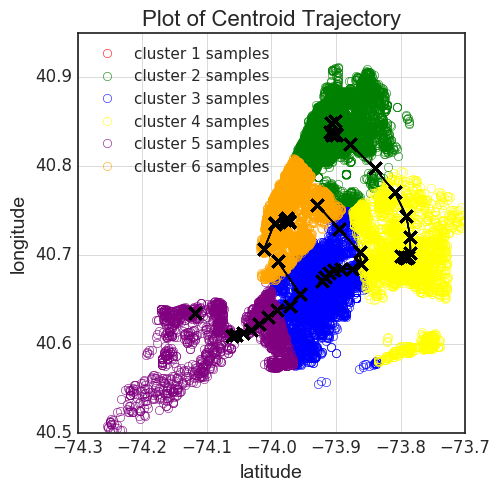

In [562]:
def compute_centroids(X, idxs):
    """
    Input: X matrix, index vector 
    Output: new centroid matrix, where each centroid = mean of X samples assigned to it
    """
    subX = []
    for x in range(len(np.unique(idxs))):
        subX.append(np.array([X[i] for i in range(X.shape[0]) if idxs[i]==x]))
    return np.array([np.mean(thisX, axis=0) for thisX in subX])

def run_kmeans(X, initial_centroids, K, n_iter):
    centroid_history = []
    current_centroids = initial_centroids
    for i in range(n_iter):
        centroid_history.append(current_centroids)
        idxs = find_closest_centroids(X, current_centroids)
        current_centroids = compute_centroids(X, idxs)
    return idxs, centroid_history

idxs, centroid_history = run_kmeans(X, initial_centroids, K, n_iter=10)
plot_data(X, centroid_history, idxs)

## Multiple clustering runs with randomized initial centroid locations:

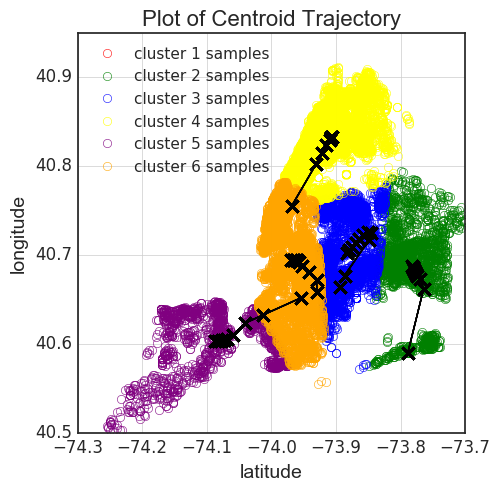

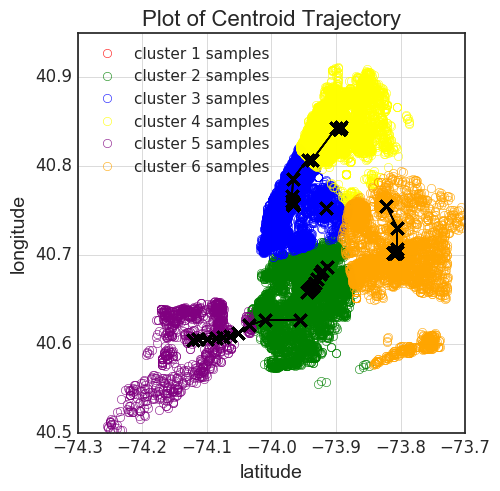

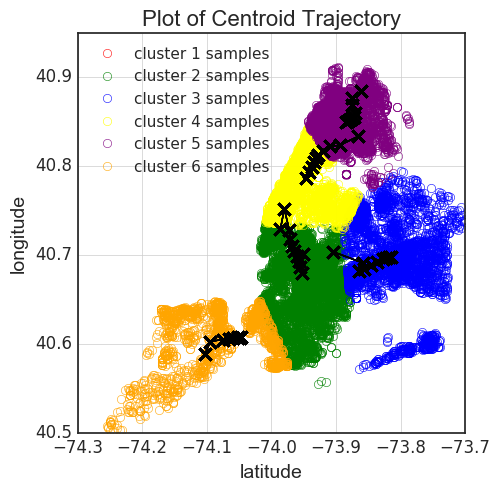

In [563]:
def random_init_centroids(X, K):
    rand_indices = random.sample(range(0, X.shape[0]), K)
    return np.array([X[i] for i in rand_indices])

# Try plotting for 3 different random initializations:
for i in range(3):
    idxs, centroid_history = run_kmeans(X, random_init_centroids(X, K), K, n_iter=10)
    plot_data(X, centroid_history, idxs)